# Разложение временных рядов с помощью метода SSA

В этом учебном пособии будет представлена техника **анализа сингулярного спектра (SSA)**, метода декомпозиции временных рядов. SSA разлагает временной ряд на набор суммируемых компонентов, которые группируются вместе и интерпретируются как *тренд*, *периодичность* и *шум*. SSA отчетливо показывает **разделимость** базовых компонент и может легко выделять цикличность, возникающую в разных временных масштабах, даже в очень зашумленных данных временных рядов. Исходный временной ряд восстанавливается путем суммирования всех его компонент.

Таким образом, SSA можно использовать для анализа и реконструкции временных рядов с различными компонентами или без них по желанию. Примеры использования SSA:
* Сглаженная версия временного ряда, с использованием небольшого подмножества его компонентов;
* Поиск периодических компоненты временного ряда, чтобы понять основные процессы, которые породили временной ряд;
* Реконструировать исходный временной ряд без его периодических составляющих;
* Удаление всех трендовых и периодических компонент из ряда, оставив только "шум", который может иметь значение.



In [2]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)


def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

# 1. Загрузка данных <a name="Section1"></a>

In [3]:
data = pd.read_csv("data_gulf_of_finland.csv")
data = data.loc[data["NAME"] == "BELOGORKA, RS"] # берем ежедневные данные о температуре, собранные с 1 станции в ЛО
data = data.set_index("DATE") # установим дату в качестве индекса
data.TEMP = (data.TEMP - 32) * 5/9 # преобразуем из градусов по Фаренгейту в градусы по Цельсию
data["TEMP"] # всего у нас 2651 записей с  2012 по 2020 год

DATE
2012-09-01     8.000000
2012-09-02    12.000000
2012-09-03    13.777778
2012-09-04    12.944444
2012-09-05    14.611111
                ...    
2019-12-29    -5.388889
2019-12-30     1.833333
2019-12-31     1.833333
2020-01-01    -1.055556
2020-01-02     2.833333
Name: TEMP, Length: 2651, dtype: float64

Text(0, 0.5, 'temp')

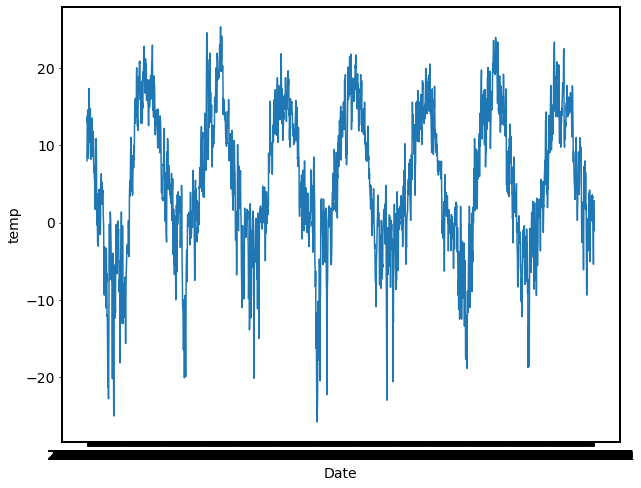

In [4]:
plt.plot(data.TEMP)
plt.xlabel("Date")
plt.ylabel("temp")

# 2. Введение в метод SSA<a name="Section2"></a>
## 2.1 Переход к таректорной матрице<a name="Section2.1"></a> 
Первым шагом SSA является сопоставление временного ряда $F$ с последовательностью многомерных векторов задержек. Пусть целое число $L$ будет длиной **окна**, $2 \le L \le N/2$. Таким образом формируется окно из подпоследовательностей $\{f_i, \ f_{i+1}, \ldots , \ f_{i+L-1}\}$, для  $i=0,\ldots,N-L$.

\begin{align*}
X_0 & = (f_0, \ f_1, \ f_2,  \ldots, \ f_{L-1} )^{\text{T}} \\
X_1 & = (f_1, \ f_2, \ f_3,  \ldots, \ f_L )^{\text{T}} \\
X_2 & = (f_2, \ f_3, \ f_4,  \ldots, \ f_{L+1} )^{\text{T}} \\
X_3 & = (f_3, \ f_4, \ f_5,  \ldots, \ f_{L+2} )^{\text{T}} \\
& \quad \quad \quad  \vdots \\
X_{N-L} & = (f_{N-L}, \ f_{N-L+1}, \ f_{N-L+2}, \ \ldots, \ f_{N-1} )^{\text{T}}.
\end{align*}

Эти вектора образуют $L$-*траекторной матрицы*, $\mathbf{X}$, временного ряда:

$$\mathbf{X} = \begin{bmatrix}
f_0 & f_1 & f_2 & f_3 &\ldots & f_{N-L} \\ 
f_1 & f_2 & f_3 & f_4 &\ldots & f_{N-L+1} \\
f_2 & f_3 & f_4 & f_5 &\ldots & f_{N-L+2} \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
f_{L-1} & f_{L} & f_{L+1} & f_{L+2} & \ldots & f_{N-1} \\ 
\end{bmatrix}$$

Из приведенной выше матрицы видно, что элементы *антидиагоналей* (то есть диагоналей, идущих снизу слева направо) равны. Этот тип матрицы известен как ***Ганкелева*** матрица.

$K = N - L + 1$ представляют количество столбцов в матрице траекторий. **Мы будем называть столбцы $\mathbf{X}$ векторами задержек $L$, а строки-векторами задержек $K$.**

In [6]:
F = data.TEMP[:1000].values
N = len(F)
L = round(N * 0.3) # Длина окна - 30% от длины ряда
print(N, L)
K = N - L + 1 # Число колонок в траекторной матрице
# Создаем траекторную матрицу, вытянув соответствующие подпоследовательности из F и сложив их в виде столбцов.
X = np.column_stack([F[i:i+L] for i in range(0,K)])
# Примечание: i+L выше дает нам до i+L-1, так как верхние границы массива numpy не включаются.

1000 300


Text(0.5, 1.05, 'Траекторная матрица')

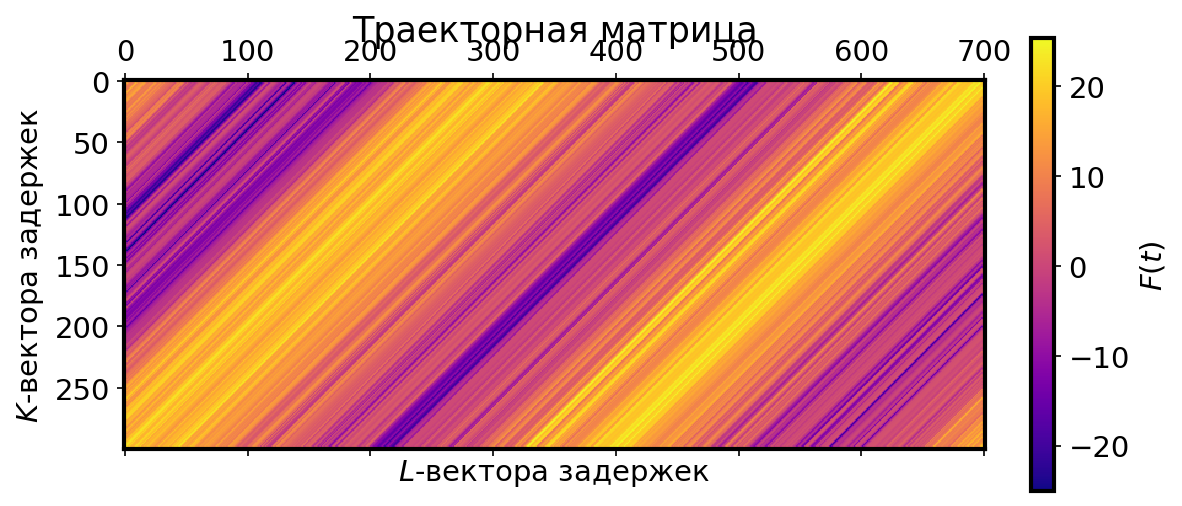

In [7]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax = ax.matshow(X)
plt.xlabel("$L$-вектора задержек")
plt.ylabel("$K$-вектора задержек")
fig.colorbar(ax, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("Траекторная матрица", pad=15)

Визуализация траекторной матрицы:
1. Элементы на антидиагоналях равны
2. Значения чередуются с определенным шагом

## 2.2 Разложение траекторной матрицы<a name="Section2.2"></a>
Разложим нашу траекторную матрицу с помощью SVD [singular-value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular-value_decomposition),

$$\mathbf{X} = \mathbf{U\Sigma V}^{\text{T}}$$ 
где:
* $\mathbf{U}$ размера $L \times L$ ортонормированная матрица ***левых сингулярных векторов*** of $\mathbf{X}$;
* $\mathbf{\Sigma}$ размера $L \times K$ прямоугольная диагональная матрица $L$ ***сингулярных значений*** of $\mathbf{X}$, упорядоченных от большего к меньшему;
* $\mathbf{V}$ размера $K \times K$ ортонормированная матрица ***правых сингулярных векторов*** of $\mathbf{X}$.

мы перевели временной ряд $F = \{f_0, \ldots, f_{N-1}\}$ в набор векторов-столбцов, $X_i = (f_i, f_{i+1}, \ldots, f_{i+L-1})^{\text{T}}, i = 0, \ldots, N-L$, которые образуют траекторную матрицу $\mathbf{X}$. Потом разложили через SVD; нашли два ортонормированных базиса, $\mathcal{U}$ and $\mathcal{V}$, которые образуют пространство строк и колонок траекторной матрицы.
\begin{align*}
    \mathbf{X} & = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}} \\
               & \equiv \sum_{i=0}^{d-1}\mathbf{X}_i
\end{align*}
$i$-ое сингулярное значение $\sigma_i$, определяет относительный вклад $\mathbf{X}_i$ в $\mathbf{X}$. Число $d \le L$ может быть выбрано для получение аппроксимации пониженной размерности $\mathbf{X}$ сумммируя только первые $r < d$ элементарных матриц.

 Сфокусируемся на восстановлении компонентов временного ряда по его элементарным матрицам.

In [9]:
d = np.linalg.matrix_rank(X) 

U, Sigma, V = np.linalg.svd(X)
V = V.T 

# Вычислите элементарные матрицы X, сохранив их в многомерном массиве NumPy. Для этого требуется вычислить sigma_i * U_i * (V_i)^T для каждого i 
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Быстрая проверка: сумма всех элементарных матриц в X_elm должна быть равна X, с точностью до определенного порога:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

Рассмотрим первые 16 элементарных матриц

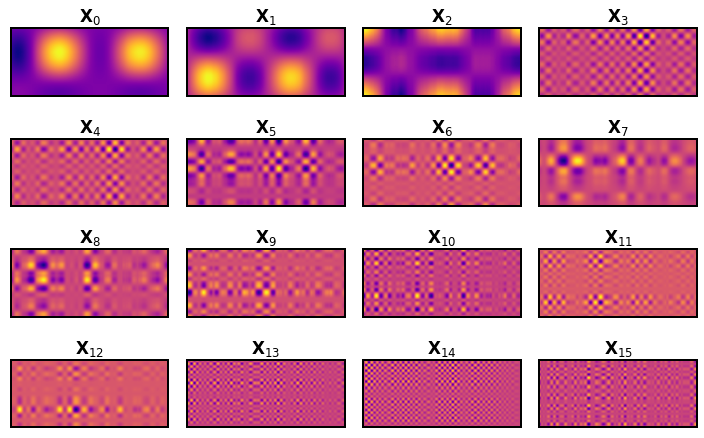

In [44]:
n = min(16, d) 
for i in range(n):
    plt.subplot(5,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

Из визуального осмотра $\mathbf{X}_i$ очевидно, что элементарным матрицам не хватает антидиагональной структуры.

Матрицы $\mathbf{X}_0$ - $\mathbf{X}_2$ визуально вносят наибольший вклад и являются трендовыми, либо периодическими компонентами, начиная с матрицы $\mathbf{X}_{13}$ и далее идет шум. Матрицы между ними, возможно, имеют какую-то периодичность, но скорее всего несут малый вклад, зашумлены?

Рассмотрим индивидуальный вклад каждой элементарной матрицы, $\dfrac{\sigma_i^2}{\sum_{k=0}^{d-1} \sigma_k^2}$, и совокупный вклад, $\dfrac{\sum_{j=0}^i \sigma_j^2}{\sum_{k=0}^{d-1} \sigma_k^2}$, из первых 12 элементарных матриц в траекторную матрицу временного ряда:

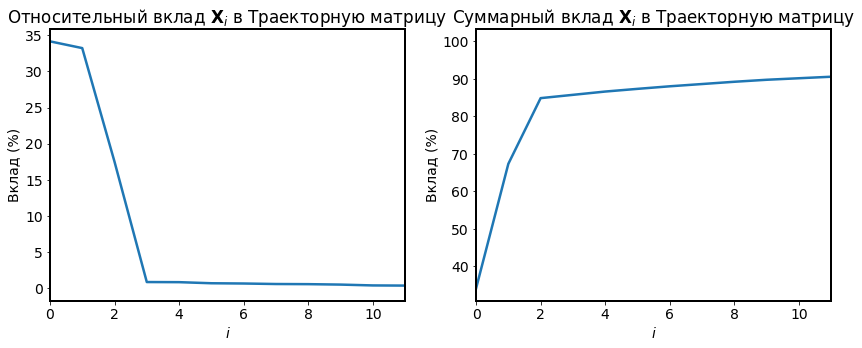

In [11]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Относительный вклад $\mathbf{X}_i$ в Траекторную матрицу")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Вклад (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Суммарный вклад $\mathbf{X}_i$ в Траекторную матрицу")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Вклад (%)");

На приведенных выше графиках показаны относительные и совокупные вклады первых 12 $\mathbf{X}_i$. Элементарные матрицы $\mathbf{X}_0$ и $\mathbf{X}_1$ вносят 34% и 33% в  $\mathbf{X}$. В совокупности первые три элементарных матриц составляют ~85%. Визуально видно, что первые две матрицы вносят примерно равный вклад и их можно обьединить. Начиная с $\mathbf{X}_3$ вклад становится менее 5% и мы не видим существенных изменений, следовательно, оставшиеся компоненты можно убрать из ряда. 


## 2.Восстановление исходного ряда<a name="Section2.3"></a>
До сих пор мы сопоставляли временной ряд $F$ с рядом векторов с запаздыванием $L$, формируя матрицу траекторий$ F$. Затем мы разложили эту матрицу с помощью сингулярного разложения и построили набор *элементарных матриц*, которые составляют матрицу траекторий. Затем мы дали небольшое объяснение, размахивая руками, чтобы классифицировать эти элементарные матрицы как *тренд*, *периодичность* и *шум*.

В идеальном мире все компоненты временного ряда $F = \sum_j F^{(j)}$ были бы разделимыми, и мы бы сгруппировали полученные элементарные матрицы $\mathbf{X}_i$ соответствующим образом, так что
\begin{align*} 
\mathbf{X} & = \sum_{k \in \mathcal{S}}\mathbf{X}_k + \sum_{l \in \mathcal{T}}\mathbf{X}_l + \ldots \\
& = \sum_j \mathbf{X}^{(j)}
\end{align*} 
где $\mathcal{S}$ и $\mathcal{T}$-непересекающиеся наборы индексов, а $\mathbf{X}^{(j)}$ - траекторная матрица компонента временного ряда $F^{(j)}$. В этом случае каждый $\mathbf{X}^{(j)}$ будет иметь Ганкелеву структуру и построение каждого $F^{(j)}$ будет простым. Однако в этом несовершенном реальном мире ни одна траекторная матрица компонентов не будет иметь равных значений на своих антидиагоналях. Поэтому мы ищем процесс преобразования элементарной матрицы в матрицу Ханкеля, а затем во временной ряд.

Чтобы извлечь временной ряд из элементарных матриц, мы будем использовать ***диагональное усреднение***, которое определяет значения восстановленного временного ряда $\tilde{F}^{(j)}$ как средние значения соответствующих антидиагоналей матриц $\mathbf{X}^{(j)}$. Формально это выполняется с помощью оператора Ганкеля. $\hat{\mathcal{H}}$, который действует на матрицу $L \times K$  $\mathbf{X}^{(j)}$ и переводит ее в Ганкелеву матрицу $\mathbf{\tilde{X}}^{(j)}$; такую что, 
$$\mathbf{\tilde{X}}^{(j)} = \hat{\mathcal{H}}\mathbf{X}^{(j)}$$ 
Элемент $\tilde{x}_{m,n}$ in $\mathbf{\tilde{X}}^{(j)}$, для $s = m+n$
$$
\tilde{x}_{m,n} = \left\{
  \begin{array}{lr}
    \frac{1}{s+1}\sum_{l=0}^{s} x_{l, s-l} & \ 0 \le s \le L-1 \\
    \frac{1}{L-1}\sum_{l=0}^{L-1} x_{l, s-l} & \ L \le s \le K-1 \\
    \frac{1}{K+L-s-1}\sum_{l=s-K+1}^{L} x_{l, s-l} & \ K \le s \le K+L-2 \\
  \end{array}
\right.
$$

На первый взгляд, все вышесказанное выглядит как ад-адок-адище. Однако все, что он делает, - это вычисляет заданную $\tilde{x}_{m,n}$ путем усреднения остальных элементов антидиагонали,к которой принадлежит $\tilde{x}_{m, n}$. Количество антидиагональных элементов для суммирования зависит от расположения $m$ и $n$ в матрице. **На практике нам не нужна полная матрица Ханкеля $\mathbf{\tilde{X}}^{(j)}$, и мы можем сразу перейти к построению временного ряда $\tilde{F}^{(j)}$. Тем не менее, я включил определение $\hat{\mathcal{H}}\mathbf{X}^{(j)}$ выше, чтобы завершить математическое изложение SSA.**

Важно отметить, что $\hat{\mathcal{H}}$ является линейным оператором, т. е. $\hat{\mathcal{H}}(\mathbf{A} + \mathbf{B}) = \hat{\mathcal{H}}\mathbf{A} + \hat{\mathcal{H}}\mathbf{B}$. Затем для матрицы траекторий $\mathbf{X}$,
\begin{align*} 
\hat{\mathcal{H}}\mathbf{X} & = \hat{\mathcal{H}} \left( \sum {i=0}^{d-1} \mathbf{X}_i \right) \\
& = \sum_{i=0}^{d-1} \hat{\mathcal{H}} \mathbf{X}_i \\
& \equiv \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}
\end{align*} 
Поскольку $\mathbf{X}$ уже является матрицей Ханкеля, то по определению $\hat{\mathcal{H}}\mathbf{X} = \mathbf{X}$. Следовательно, матрица траекторий может быть выражена в терминах ее элементарных матриц Ханкеля:
$$\mathbf{X} = \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}$$
Поскольку временной ряд однозначно определяется из матрицы Ханкеля, приведенное выше выражение также определяет временной ряд $F$ как сумму его компонентов $\tilde{F}_i$. Мы должны сгруппировать эти компоненты вместе и классифицировать их.

In [12]:
def Hankelise(X):
    L, K = X.shape
    transpose = False
    if L > K:
        # # Приведенная ниже Ганкелезиция работает только для матриц, где L < K.
        # # Чтобы изменить матрицу L > K, сначала поменяйте местами L и K и транспонируйте X.
        # Установите флаг для транспонирования HX перед возвратом.
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

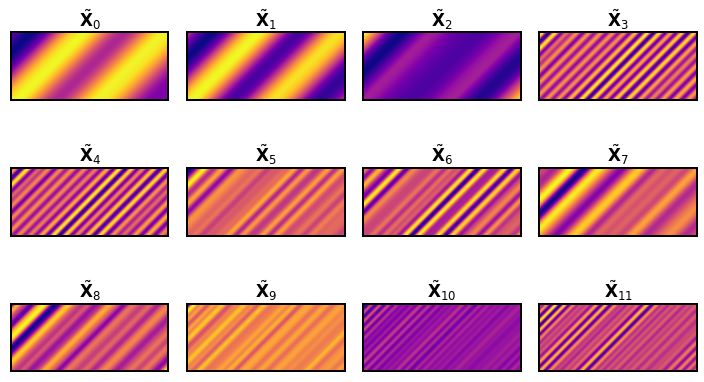

In [13]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 

Визуально кажется, будто первые 2 матрицы являются периодическими компонентами, а третья - трендом. Так или иначе, матрицы  $\tilde{\mathbf{X}}_0$ и $\tilde{\mathbf{X}}_1$ могут быть сгруппированы вместе. 
$\tilde{\mathbf{X}}_3$ и $\tilde{\mathbf{X}}_4$ выглядят практически одинаково и также могут быть сгруппированы, аналогично для $\tilde{\mathbf{X}}_7$ и $\tilde{\mathbf{X}}_8$. $\tilde{\mathbf{X}}_5$ и $\tilde{\mathbf{X}}_6$ визуально похожи, однако первая зашумлена(?), периодики с одинаковой частотой(?).
Визуально не видно очевидного шума, даже в $\tilde{\mathbf{X}}_{11}$ мы видим периодичность, схожую с $\tilde{\mathbf{X}}_3$...
Однако эти компоненты несут малый вклад. 

Подводя итог:
\begin{align*}
\tilde{\mathbf{X}}^{\text{(trend)}} & = \tilde{\mathbf{X}}_2
    & \implies &  \tilde{F}^{\text{(trend)}} = \tilde{F}_2 \\
\tilde{\mathbf{X}}^{\text{(periodic 1)}} & = \tilde{\mathbf{X}}_0 + \tilde{\mathbf{X}}_1 
    & \implies & \tilde{F}^{\text{(periodic 1)}} = \tilde{F}_0 + \tilde{F}_1  \\
\tilde{\mathbf{X}}^{\text{(periodic 2)}} & = \tilde{\mathbf{X}}_3 + \tilde{\mathbf{X}}_4 
    & \implies & \tilde{F}^{\text{(periodic 2)}} = \tilde{F}_3 + \tilde{F}_4\\
\tilde{\mathbf{X}}^{\text{(noise)}} & = \tilde{\mathbf{X}}_5 + \ldots + \tilde{\mathbf{X}}_{69}
    & \implies & \tilde{F}^{\text{(noise)}} = \tilde{F}_5 + \ldots + \tilde{F}_{69}
\end{align*}
Мы определили группировку компонентов временных рядов в терминах элементарных матриц, поэтому больше не будем вычислять полную матрицу Ханкеля $\tilde{\mathbf{X}}_i$, а вместо этого вычисляем $\tilde{F}_i$ непосредственно из $\mathbf{X}_i$. 

In [14]:
def X_to_TS(X_i):
    """Усредняет антидиагонали данной элементарной матрицы X_i и возвращает временной ряд."""
    # Изменить порядок столбцов X_i
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

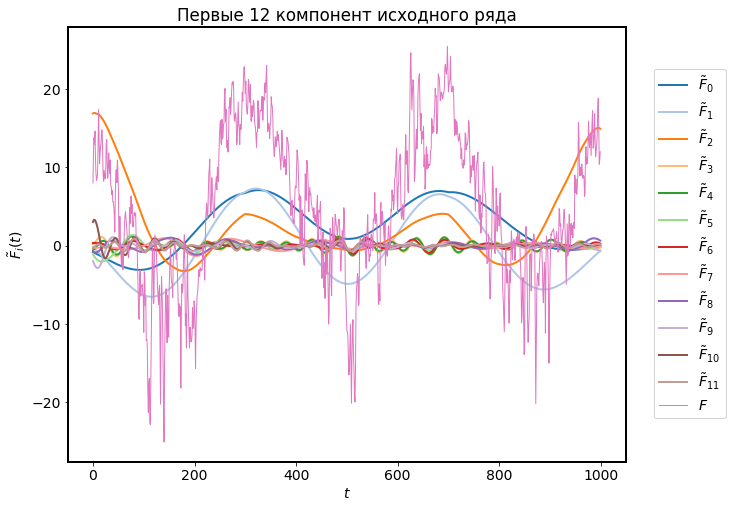

In [16]:
n = min(12,d) 
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(F_i, lw=2)

fig.axes.plot(F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("Первые 12 компонент исходного ряда")
fig.legend(legend, loc=(1.05,0.1));

$\tilde{F}_2$ напоминает тренд, $\tilde{F}_0$ и $\tilde{F}_1$ - периодики, но лучше представить их как отдельные компоненты.  

Попробуем сделать группировку для $\tilde{F}^{\text{(тренд)}}$, $\tilde{F}^{\text{(циклика 1)}}$, $\tilde{F}^{\text{(циклика 2)}}$ и $\tilde{F}^{\text{(шум)}}$, "на глаз"

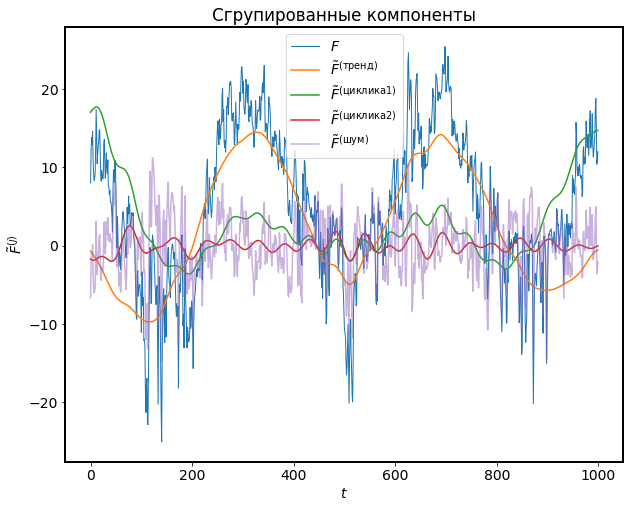

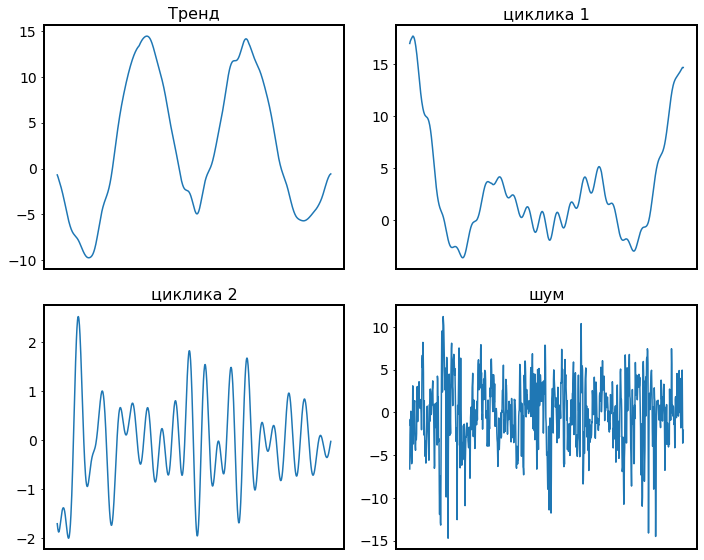

In [21]:
# Группируем элементы между собой
F_trend = X_to_TS(X_elem[[0,1,6]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[2,3]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[4,5]].sum(axis=0))
F_noise = X_to_TS(X_elem[7:].sum(axis=0))

plt.plot(F, lw=1)
plt.plot(F_trend)
plt.plot(F_periodic1)
plt.plot(F_periodic2)
plt.plot(F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["тренд", "циклика 1", "циклика 2", "шум"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Сгрупированные компоненты")
plt.show()

# A list of tuples so we can create the next plot with a loop.
components = [("Тренд", F_trend), 
              ("циклика 1",  F_periodic1),
              ("циклика 2",  F_periodic2),
              ("шум", F_noise)]

# Plot the separated components and original components together.
fig = plt.figure()
n=1
for name, ssa_comp in components:
    ax = fig.add_subplot(2,2,n)
    ax.plot(ssa_comp)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()

После того, как мы сгруппировали компоненты вместе, видно что разделение исходных компонент временного ряда—особенно двух периодических компонентов с разными частотами и амплитудами весьма неплохо, но не идеально: все компоненты ухудшаются вблизи границ, особенно тренд и вторая периодическая составляющая. Это распространено в SSA и связано с тем, что в соответствии с формализмом SSA большинство типов рядов (т. Е. полиномиальных, синусоидальных, экспоненциальных и т. Д.) не являются точно разделимыми. Поэтому наша попытка восстановить *точный* параболический тренд и периодические компоненты всегда была обречена на провал.

Однако это не означает, что компоненты временного ряда не могут быть *приблизительно разделяемыми*, как мы видели выше. (Существует также концепция *асимптотической разделимости*—когда длина временного ряда приближается к бесконечности—однако по практическим соображениям мы не будем рассматривать этот случай здесь.)

# 3. Разделение и группировка компонентов временных рядов<имя="Раздел3"></a>

До сих пор мы группировали собственные элементы/компоненты временного ряда вместе путем визуального осмотра; то есть мы решили, какие компоненты принадлежат друг другу по их внешнему виду. Это хорошо для коротких и простых временных рядов, однако для более длинных и сложных временных рядов мы ищем метод, который количественно определяет, можно ли считать реконструированный компонент $\tilde{F}_i$ отдельным от другого компонента $\tilde{F}_j$, поэтому нам не нужно принимать решения о группировке, визуально проверяя каждую $\tilde{F}_i$.

Для двух реконструированных временных рядов, $\tilde{F}_i$ и $\tilde{F}_j$, длиной $N$ и длиной окна $L$, мы определяем *взвешенное скалярное произведение*, $(\tilde{F}_i, \tilde{F}_j)_w$ как:
$$(\tilde{F}_i, \tilde{F}_j)_w = \sum {k=0}^{N-1} w_k \tilde{f}_{i,k} \tilde{f}_{j,k}$$
где $\tilde{f}_{i,k}$ и $\tilde{f}_{j,k}$ находятся в $k$ - ых значениях $\tilde{F}_i$ и $\tilde{F}_j$, соответственно, и $w_k$ дается
$$
w_{k} = \left\{
  \begin{array}{lr}
    k+1 & \ 0 \le k \le L-1 \\
    L & \ L \le k \le K-1 \\
    N - k & \ K \le k \le N-1 \\
  \end{array}
\right.
$$
помня, что $K = N - L + 1$. Вес $w_k$ просто отражает количество раз, когда $\tilde{f}_{i,k}$ и $\tilde{f}_{j,k}$ появляются в матрицах Ганкеля $\mathbf{\tilde{X}}_i$ и $\mathbf{\tilde{X}}_j$, из которых были получены временные ряды $\tilde{F}_i$ и $\tilde{F}_j$.

Проще говоря, если $(\tilde{F}_i, \tilde{F}_j)_w = 0$, $\tilde{F}_i$ и $\tilde{F}_j$ являются *w-ортогональными* и компоненты временных рядов разделимы. Конечно, полная w-ортогональность не встречается в реальной жизни, поэтому вместо этого мы определяем матрицу $d \times d$ ***взвешенной корреляции***, $\mathbf{W}_{\text{corr}}$, которая измеряет отклонение компонентов $\tilde{F}_i$ и $\tilde{F}_j$ от w-ортогональности. Элементы $\mathbf{i}_{\text{Corr}}$ дает
$$W_{i,j} = \frac{(\tilde{F}_i, \tilde{F}_j)_w}{\lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w}$$
where $\lVert \tilde{F}_k \rVert_w = \sqrt{(\tilde{F}_k, \tilde{F}_k)_w}$ for $k = i,j$. The interpretation of $W_{i,j}$ is straightforward: if $\tilde{F}_i$ and $\tilde{F}_j$ are arbitrarily close together (but not identical), then $(\tilde{F}_i, \tilde{F}_j)_w \rightarrow \lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w$ and therefore $W_{i,j} \rightarrow 1$. Если $\tilde{F}_i$ и $\tilde{F}_j$ ортогональны, тогда $W_{i,j} = 0$. Значения $W_{i,j}$ находятся в пределах от 0 до 1 и указывают $W_{i,j} \ge 0.3$ какие компоненты надо сгруппировать.

In [22]:
# Сначала получите веса w, так как они будут часто использоваться повторно.
# Примечание: список(np.arange(L)+1) возвращает последовательность от 1 до L (первая строка в определении w),
# [L]*(K-L-1) повторяет L K-L-1 раз (вторая строка в определении w)
# список(np.arange(L)+1)[::-1] отменяет первый список (эквивалентно третьей строке)
# Сложите все списки вместе, и у нас будет наш массив весов.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Получите все компоненты серии игрушек, сохраните их в виде столбцов в массиве F_elem.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Вычислите индивидуальные взвешенные нормы, ||F_i||_w, сначала, затем возьмите обратный квадратный корень, чтобы нам не пришлось делать это позже.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Вычислите матрицу w-corr. Диагональные элементы равны 1, поэтому мы можем начать с матрицы идентичности
# и повторите все пары i и j (i != j), отметив, что Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

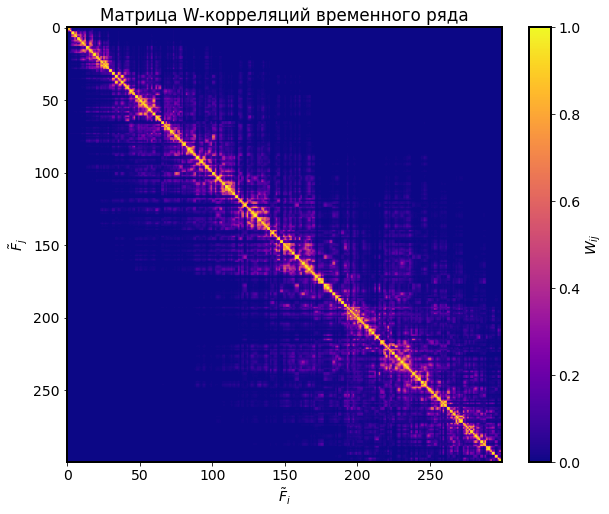

In [23]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("Матрица W-корреляций временного ряда");

Структура $\mathbf{W}_{\text{corr}}$ показывает большую корреляцию между компонентами временных рядов, особенно в диапазоне $7 \le i,j \le 69$. Поскольку это были компоненты, которые мы классифицировали как принадлежащие к шуму во временном ряду, неудивительно, что между ними всеми существуют незначительные корреляции; это естественный результат того, что шум не имеет базового структурного компонента, который можно было бы дополнительно разделить.

Важно отметить, что $\mathbf{W}_{\text{corr}}$ примерно разделен на два "блока": $0 \le i,j \le 6$ и $7 \le i,j \le 69$. Это соответствует двум основным группам: сглаженный временной ряд (т. е. тренд плюс две периодические компоненты) и остаточный шум. Масштабирование первых семи компонентов в $\mathbf{W}_{\text{corr}}$:

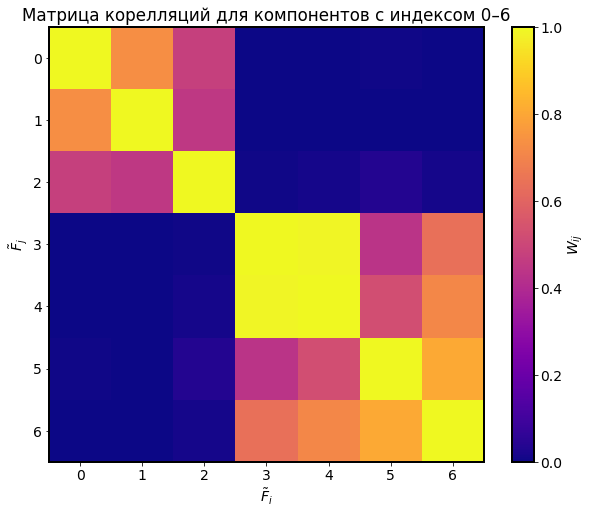

In [24]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,6.5)
plt.ylim(6.5,-0.5)
plt.clim(0,1)
plt.title(r"Матрица корелляций для компонентов с индексом 0–6");

Первоначальные группировки на основе внешнего вида, которые мы сделали для первых шести компонентов, поддерживаются соответствующими значениями w-корреляции. $\tilde{F}_0$ и $\tilde{F}_1$ имеют $W_{0,1} = 0,40$, предполагая, что они должны быть сгрупированы. $\tilde{F}_1$ и $\tilde{F}_6$ также имеют $W_{1,6} = 0,39$, предполагая, что $\tilde{F}_6$ также должна быть сгруппирована с $\tilde{F}_0$ и $\tilde{F}_1$ в качестве компонента тренда. Тем не менее, $\tilde{F}_6$ также имеет небольшую w-корреляцию с $\tilde{F}_4$ и $\tilde{F}_5$, но поскольку $\tilde{F}_4$ и $\tilde{F}_5$ не имеют w-корреляции с $\tilde{F}_0$ и $\tilde{F}_1$, мы решили оставить $\tilde{F}_6$ с $\tilde{F}_0$ и $\tilde{F}_1$.

Наши предыдущие группировки $\tilde{F}^{\text{(периодическая 1)}} = \tilde{F}_2 + \tilde{F}_3$ и $\tilde{F}^{\text{(периодическая 2)}} = \tilde{F}_4 + \tilde{F}_5$ четко обоснованы матрицей w-корреляции с $W_{2,3} = 0,98$ и $W_{4,5} = 0,98$.

(Кое—что для размышления: элементарные компоненты $\tilde{F}_2$ и $\tilde{F}_3$ для  временного ряда почти идентичны, за исключением границ, где они расходятся-см. График *Первые 12 компонент временного ряда* . Однако w-корреляция для $\tilde{F}_2$ и $\tilde{F}_3$ почти равна 1. Почему расхождение границ не оказало существенного влияния на w-корреляцию здесь?)

# 4. A Python Class for SSA<a name="Section4"></a>


In [25]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

# 5. Длина окна<a name="Section5"></a>

### 5.1 $L = 2$ <a name="Section5.1"></a>
Длина окна 2 может показаться бесполезным выбором но показательным.

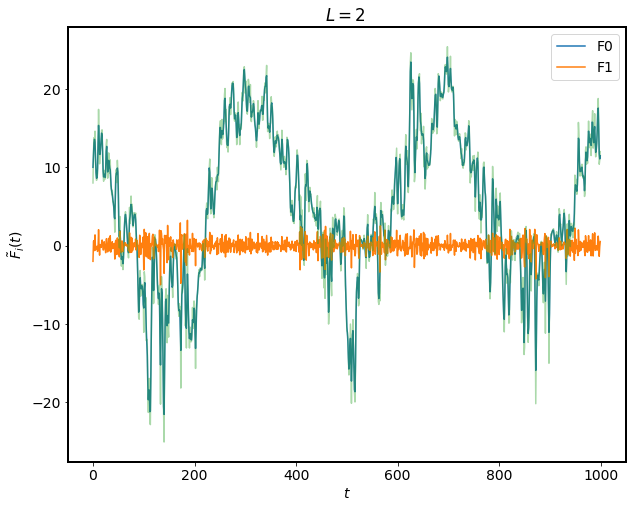

In [26]:
F_ssa_L2 = SSA(F, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ ");

Для $L=2$ мы можем ожидать возврата только двух элементарных компонентов. Даже при такой небольшой длине окна алгоритм SSA начал отделять высокочастотный шум от серии, предоставляя нам несколько уменьшенную версию исходной серии в компоненте $\tilde{F}_0$.

## 5.2 $L = 5$<a name="Section5.2"></a>

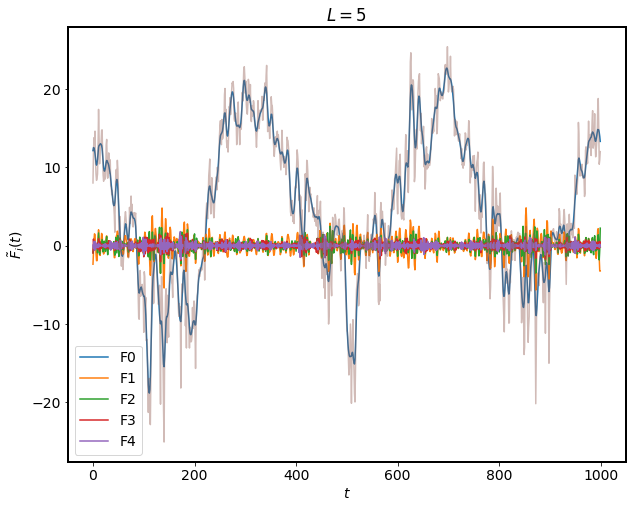

In [27]:
F_ssa_L5 = SSA(F, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$");
plt.show()

Мы видим, что $\tilde{F}_0$ теперь является версией оригинального временного ряда без шума. $\tilde{F}_1$ - это "плохое приближение" периодической составляющей, в то время как $\tilde{F}_2$ - $\tilde{F}_4$ - это просто шум.

## 5.3 $L = 20$<a name="Section5.3"></a>

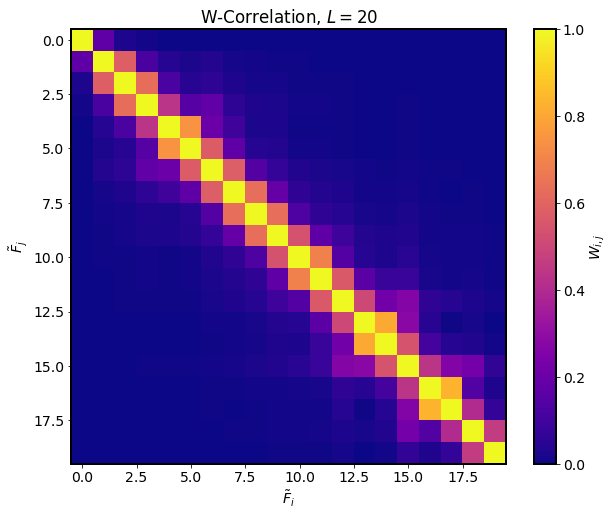

In [28]:
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation, $L=20$");

Матрица w-корреляции для $L=20$ разделена (грубо) на два блока: $\tilde{F}_0$ на $\tilde{F}_3$ и $\tilde{F}_4$ на $\tilde{F}_{19}$. В пределах этих блоков размер значений $W_{i, j}$ предполагает,что нам нужно сгруппировать $\tilde{F}_1$, $\tilde{F}_2$ и $\tilde{F}_3$ и сгруппировать все $ \tilde{F}_4, \ldots,\tilde{F}_{19}$. Эта группировка, безусловно, не идеальна, так как $\tilde{F}_3$ имеет не пренебрежимо малую w-корреляцию с компонентами во втором блоке. Мы построим выбранные нами группировки компонентов вместе с $\tilde{F}_3$ самостоятельно и посмотрим, оправдан ли наш выбор группировки:

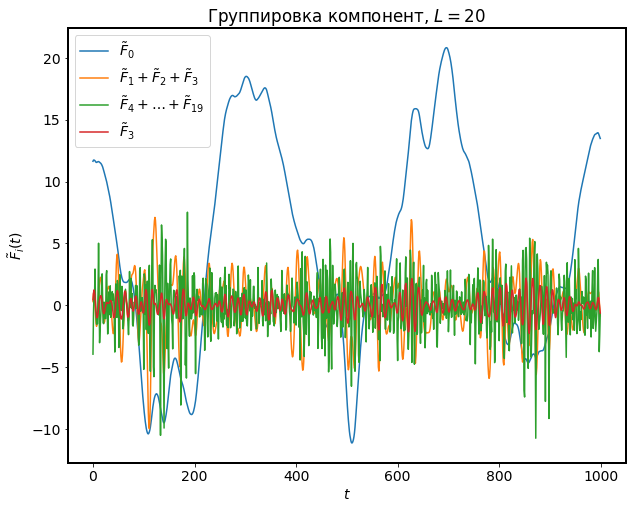

In [29]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2,3]).plot()
F_ssa_L20.reconstruct(slice(4,20)).plot()
F_ssa_L20.reconstruct(3).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Группировка компонент, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3$", 
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{19}$",
            r"$\tilde{F}_3$"]);

При $L = 20$ мы начинаем видеть тенденцию, и периодические компоненты начинают формироваться. Одиночный компонент $\tilde{F}_0$ выглядит как параболический тренд, а группа $\tilde {F}_1 + \tilde{F}_2 + \tilde{F}_3$ - очень красивая периодичность, соответствующая сумме двух периодических компонент. Компонент $\tilde{F}_3$ вызывает проблемы, похоже, что он вносит свой вклад как в шум*, так и в периодичность. Это говорит о том, что нам нужно увеличить длину окна и посмотреть, получим ли мы улучшенное разделение шума и периодичности.

## 5.4 $L = 40$<a name="Section5.4"></a>


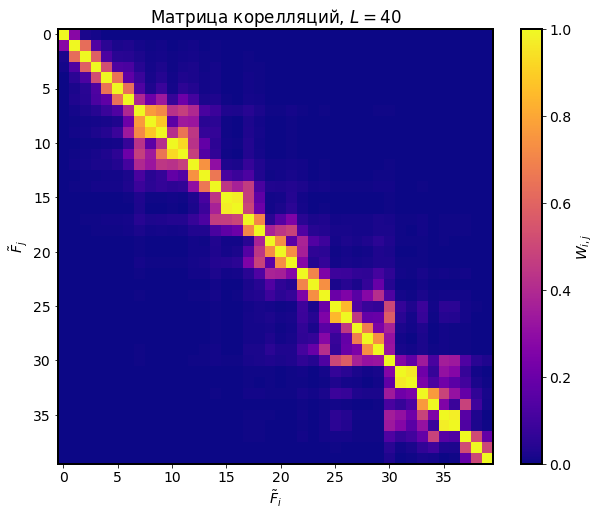

In [30]:
F_ssa_L40 = SSA(F, 40)
F_ssa_L40.plot_wcorr()
plt.title("Матрица корелляций, $L=40$");

Матрица w-корреляции для $L=40$ сохраняет двухблочную структуру, с $\tilde{F}_0, \ldots, \tilde{F}_5$ в первом блоке и $\tilde{F}_6, \ldots, \tilde{F}_{39}$ во втором. Давайте сгруппируем компоненты следующим образом:
\begin{align*}
    \tilde{F}^{(0)} & = \tilde{F}_0 \\
    \tilde{F}^{(1)} & = \tilde{F}_1 + \tilde{F}_2 + \tilde{F}_3 \\
    \tilde{F}^{(2)} & = \tilde{F}_4 + \tilde{F}_5 \\
    \tilde{F}^{(3)} & = \tilde{F}_6 + \ldots + \tilde{F}_{39} \\
\end{align*}
Конечно группировка не идеальна, учитывая не пренебрежимо малую w-корреляцию, например, между $\tilde{F}_0$ и $\tilde{F}_1$.

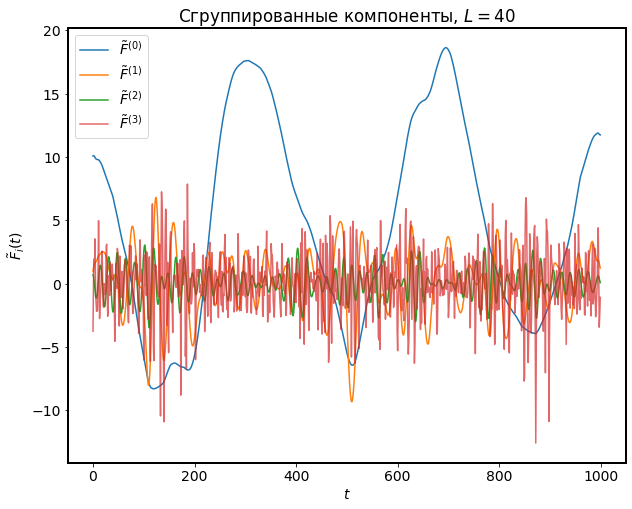

In [31]:
F_ssa_L40.reconstruct(0).plot()
F_ssa_L40.reconstruct([1,2,3]).plot()
F_ssa_L40.reconstruct([4,5]).plot()
F_ssa_L40.reconstruct(slice(6,40)).plot(alpha=0.7)
plt.title("Сгруппированные компоненты, $L=40$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)]);

Интересно, что компонент тренда $\tilde{F}^{(0)}$ начал ухудшаться при $L=40$, с заметными "перегибами" во временном ряду. Периодичность теперь разделена на две периодические составляющие с различными амплитудами и частотами, однако со значительными ухудшениями вблизи начала и конца временного ряда. На данном этапе длина нашего окна составляет 20% от длины временного ряда, но низкое качество отдельных компонентов говорит о том, что нам все еще необходимо увеличить размер окна.

## 5.5 $L = 60$<a name="Section5.5"></a>
Сейчас мы приближаемся к нашему первому выбору $L=70$, поэтому стоит изучить, как разложение сходится к нашим первоначальным результатам. Сначала проверим матрицу w-корреляции

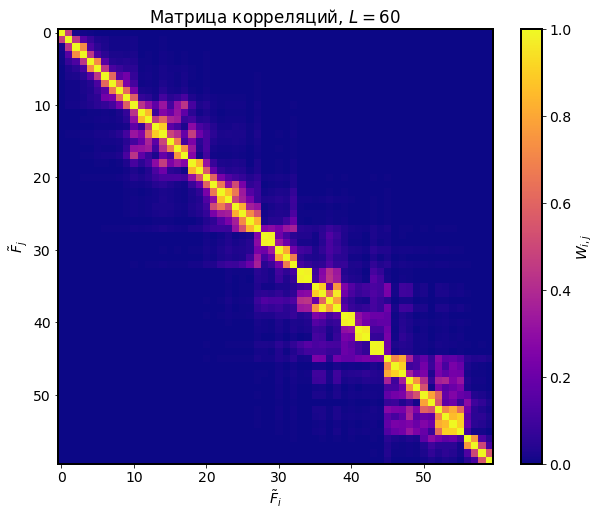

In [32]:
F_ssa_L60 = SSA(F, 60)
F_ssa_L60.plot_wcorr()
plt.title("Матрица корреляций, $L=60$");

Как и в исходном результате $L=70$, матрица w-корреляции теперь состоит из двух отдельных блоков: $\tilde{F}_0$ до $\tilde{F}_6$ и $\tilde{F}_7$ до $\tilde{F}_{59}$. Из опыта теперь ясно, что $\tilde{F}^{\text{(signal)}} = \sum {i=0}^6 \tilde{F}_i$ будет комбинированной тенденцией и периодическими компонентами ("сигнал"), а $\tilde{F}^{\text{(noise)}} = \sum {i=7}^{59} \tilde{F}_i$ будет шумом:

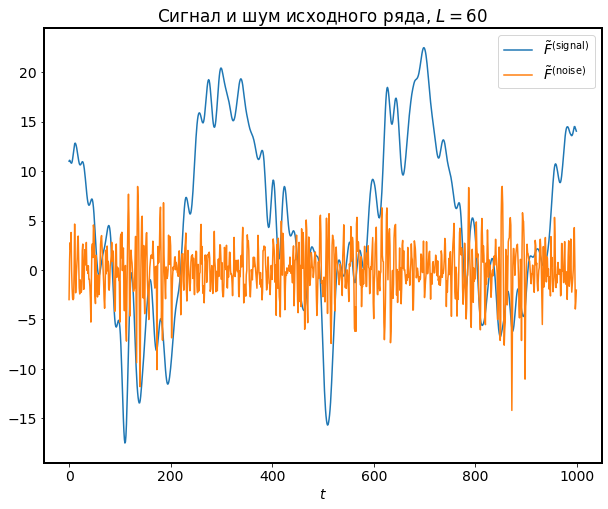

In [33]:
F_ssa_L60.reconstruct(slice(0,7)).plot()
F_ssa_L60.reconstruct(slice(7,60)).plot()
plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Сигнал и шум исходного ряда, $L = 60$")
plt.xlabel(r"$t$");

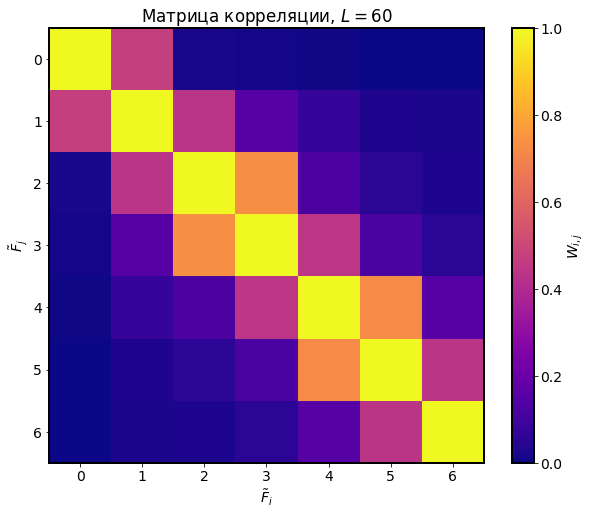

In [34]:
F_ssa_L60.plot_wcorr(max=6)
plt.title("Матрица корреляции, $L=60$");

Чтобы понять, почему существует незначительная w-корреляция между большинством из первых семи компонентов, будет разумно построить их все сразу:

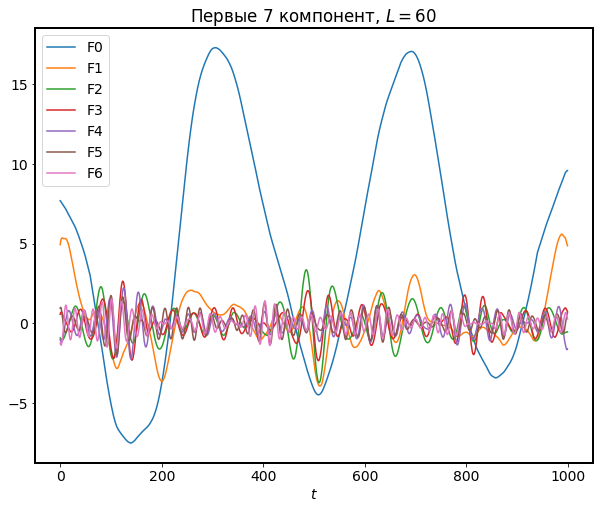

In [35]:
F_ssa_L60.components_to_df(n=7).plot()
plt.title(r"Первые 7 компонент, $L=60$")
plt.xlabel(r"$t$");

Из приведенного выше графика ясно, что компонент тренда $\tilde{F}_1$ содержит колебания той же частоты, что и периодические компоненты $\tilde{F}_2$ и $\tilde{F}_3$, что приводит к существенным w-корреляциям. Как мы уже видели (см. [Раздел 2.3](#Раздел2.3)), увеличения длины окна до $L = 70$ достаточно, чтобы почти полностью устранить эти колебания. Безусловно, можно увеличить длину окна еще больше—в этом случае до $L = N/2 = 100$, однако, помимо $L=70$, компоненты временных рядов, генерируемые ведущими семью собственными числами, (относительно) нечувствительны к длине окна.

В SSA нет жестких и быстрых правил для установки идеальной длины окна, превышающей $2 \le L \le N/2$. Однако иногда требуется более длинная длина окна (до 30-45% длины временного ряда), чтобы адекватно отделить основные периодичности от общей тенденции. Необходимы некоторые проб и ошибок, но часто бывает легко начать с "достаточно большой" длины окна и работать оттуда.

(Упражнение: почему длина окна $L$ ограничена диапазоном $2 \le L \le N/2$? Подсказка: рассмотрим выражение для SVD транспонированной матрицы траекторий, $\mathbf{X}^{\text{T}} = \mathbf{V \Sigma}^{\text{T}}\mathbf{U}^{\text{T}}$, для матрицы траекторий, когда $N/2 < L < N$.) 
